<p><font size="6"><b>Xarray advanced</b></font></p>


> *DS Python for GIS and Geoscience*  
> *September, 2023*
>
> *© 2023, Joris Van den Bossche and Stijn Van Hoey. Licensed under [CC BY 4.0 Creative Commons](http://creativecommons.org/licenses/by/4.0/)*

---

Acknowledgments to the data service: https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land-monthly-means?tab=overview

In [2]:
import xarray as xr
import rioxarray as rxr
import numpy as np
import matplotlib.pyplot as plt

import cmocean

%matplotlib inline

## `xarray.Dataset` for multiple variables

We already know `xarray.DataArray`, it is a single multi-dimensional array and each dimension can have a name and coordinate values. Next to the `DataArray`, `xarray` has a second main data structure to store arrays, i.e. `xarray.DataSet`. 

Let's read an xarray data set (global rain/temperature coverage stored in the file `2016-2017_global_rain-temperature.nc`), using the function `open_dataset`:

In [3]:
# I recall there being an issue with rxr.open_rasterio and refusing to close the dataset after opening
# leads to significant memory problems resulting in me needing to go back to basic rasterio

# could be a jupyter notebook thing as well

# It may be that xr.open_dataarray won't have this problem - will need to test
ds = xr.open_dataset("./data/2016-2017_global_rain-temperature.nc", engine="netcdf4")
ds

<xarray.Dataset>
Dimensions:        (y: 347, x: 720, year: 2)
Coordinates:
  * y              (y) float64 83.25 82.75 82.25 81.75 ... -88.75 -89.25 -89.75
  * x              (x) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * year           (year) int64 2016 2017
Data variables:
    precipitation  (year, y, x) float32 ...
    temperature    (year, y, x) float32 ...

<div class="alert alert-info" style="font-size:120%">

**REMEMBER**: <br>

xarray provides reading function for different formats with the `open_dataset` and `open_dataarray` functions. For GIS formats such as geotiff and other GDAL readable raster data, the rasterio engine (`engine="rasterio"`) is available after the installation of [rioxarray](https://corteva.github.io/rioxarray/stable/). NetCDF-alike data formats can also be loaded using the `open_dataset()` function using a NetCDF-compatible engine, e.g. `netcdf` or `h5netcdf`. The netcdf-engine will be _guessed_ by default.

</div>

Let's take a closer look at this `xarray.Dataset`:

- A `xarray.Dataset` is the second main data type provided by xarray
- This example has 3 __dimensions__:
    - `y`: the y coordinates of the data set
    - `x`: the x coordinates of the data set
    - `year`: the year coordinate of the data set
- Each of these dimensions are defined by a __coordinate__ (1D) array
- It has 2 __Data variables__: `precipitation` and `temperature` that both share the same coordinates

Hence, a `Dataset` object stores *multiple* arrays that have shared dimensions (__Note:__ not all dimensions need to be shared).  It is designed as an in-memory representation of the data model from the netCDF file format.

![](http://xarray.pydata.org/en/stable/_images/dataset-diagram.png)

In [4]:
ds["temperature"].shape, ds["temperature"].dims

((2, 347, 720), ('year', 'y', 'x'))

The data and coordinate variables are also contained separately in the `data_vars` and `coords` dictionary-like attributes of a `xarray.DataSet` to access them directly:

- The data variables:

In [5]:
ds.data_vars

Data variables:
    precipitation  (year, y, x) float32 ...
    temperature    (year, y, x) float32 ...

- The data coordinates:

In [6]:
ds.coords

Coordinates:
  * y        (y) float64 83.25 82.75 82.25 81.75 ... -88.25 -88.75 -89.25 -89.75
  * x        (x) float64 -179.8 -179.2 -178.8 -178.2 ... 178.2 178.8 179.2 179.8
  * year     (year) int64 2016 2017

In [12]:
# No CRS information in this one
ds.rio.crs

If you rather use an alternative name for a given variable, use the `rename` method:

In [7]:
# Remember that there is no inplace functionality
ds.rename({"precipitation": "rain"})

<xarray.Dataset>
Dimensions:      (y: 347, x: 720, year: 2)
Coordinates:
  * y            (y) float64 83.25 82.75 82.25 81.75 ... -88.75 -89.25 -89.75
  * x            (x) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * year         (year) int64 2016 2017
Data variables:
    rain         (year, y, x) float32 ...
    temperature  (year, y, x) float32 ...

__Note:__ _the renaming is not entirely correct as rain is just a part of all precipitation (see https://en.wikipedia.org/wiki/Precipitation)._

Adding new variables to the data set is very similar to Pandas/GeoPandas:

In [8]:
# Very similar to pandas syntax
ds["precipitation_m"] = ds["precipitation"]/1000.

In [9]:
ds

<xarray.Dataset>
Dimensions:          (y: 347, x: 720, year: 2)
Coordinates:
  * y                (y) float64 83.25 82.75 82.25 ... -88.75 -89.25 -89.75
  * x                (x) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * year             (year) int64 2016 2017
Data variables:
    precipitation    (year, y, x) float32 nan nan nan nan ... 0.8 0.8 0.8 0.8
    temperature      (year, y, x) float32 ...
    precipitation_m  (year, y, x) float32 nan nan nan ... 0.0008 0.0008 0.0008

### Selecting `DataSet` data

Each of the data variables can be accessed as a single `xarray.DataArray` similar to selecting from dictionaries or columns from DataFrames:

In [10]:
# dataarrays that can be manipulated same as the previous notebook
type(ds["precipitation"]), type(ds["temperature"])

(xarray.core.dataarray.DataArray, xarray.core.dataarray.DataArray)

One can select multiple variables at the same time as well by passing a list of variable names:

In [11]:
# Still returns Dataset
ds[["temperature", "precipitation"]]

<xarray.Dataset>
Dimensions:        (year: 2, y: 347, x: 720)
Coordinates:
  * y              (y) float64 83.25 82.75 82.25 81.75 ... -88.75 -89.25 -89.75
  * x              (x) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * year           (year) int64 2016 2017
Data variables:
    temperature    (year, y, x) float32 ...
    precipitation  (year, y, x) float32 nan nan nan nan nan ... 0.8 0.8 0.8 0.8

Or the other way around, use the `drop_vars` to drop variables from the data set:

In [12]:
ds.drop_vars("temperature")

<xarray.Dataset>
Dimensions:          (y: 347, x: 720, year: 2)
Coordinates:
  * y                (y) float64 83.25 82.75 82.25 ... -88.75 -89.25 -89.75
  * x                (x) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * year             (year) int64 2016 2017
Data variables:
    precipitation    (year, y, x) float32 nan nan nan nan ... 0.8 0.8 0.8 0.8
    precipitation_m  (year, y, x) float32 nan nan nan ... 0.0008 0.0008 0.0008

<div class="alert alert-info" style="font-size:120%">

**NOTE**: <br>

Selecting a single variable using `[]` results into a `xarray.DataArray`, selecting multiple variables using a list `[[..., ...]]` results into a `xarray.DataSet`. Using `drop_vars` always returns a `xarray.DataSet`.

</div>

The selection with `sel` works as well with `xarray.DataSet`, selecting the data _for all variables in the DataSet_ and returning a DataSet:

In [13]:
ds.sel(year=2016)

<xarray.Dataset>
Dimensions:          (y: 347, x: 720)
Coordinates:
  * y                (y) float64 83.25 82.75 82.25 ... -88.75 -89.25 -89.75
  * x                (x) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
    year             int64 2016
Data variables:
    precipitation    (y, x) float32 nan nan nan nan nan ... 0.2 0.2 0.2 0.2 0.2
    temperature      (y, x) float32 ...
    precipitation_m  (y, x) float32 nan nan nan nan ... 0.0002 0.0002 0.0002

The inverse of the `sel` method is the `drop_sel` which returns a DataSet with the enlisted indices removed:

In [14]:
# note the use of the parentheses
ds.drop_sel(year=[2016])

<xarray.Dataset>
Dimensions:          (y: 347, x: 720, year: 1)
Coordinates:
  * y                (y) float64 83.25 82.75 82.25 ... -88.75 -89.25 -89.75
  * x                (x) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * year             (year) int64 2017
Data variables:
    precipitation    (year, y, x) float32 nan nan nan nan ... 0.8 0.8 0.8 0.8
    temperature      (year, y, x) float32 ...
    precipitation_m  (year, y, x) float32 nan nan nan ... 0.0008 0.0008 0.0008

### DataSet plotting

Plotting for data set level is rather limited. A typical use case that is supported to compare two data variables are scatter plots:

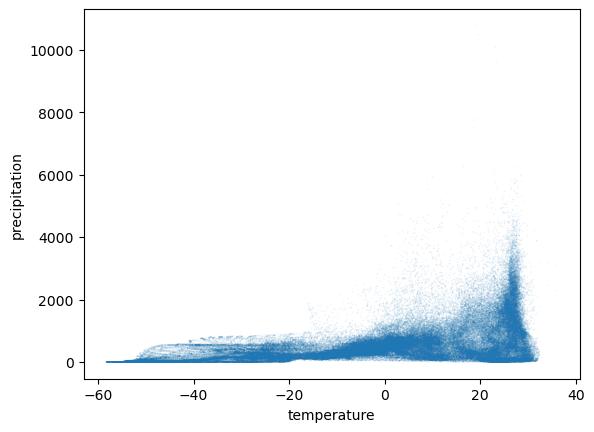

In [15]:
# Dataset plotting is poor - generally use plt.subplots to create multiple individual plots for each data variable
ds.plot.scatter(x="temperature", y="precipitation", s=1, alpha=0.1, edgecolor="none")

`facetting` is also supported here, by linking the `col` or `row` parameter to a data variable (a coord).

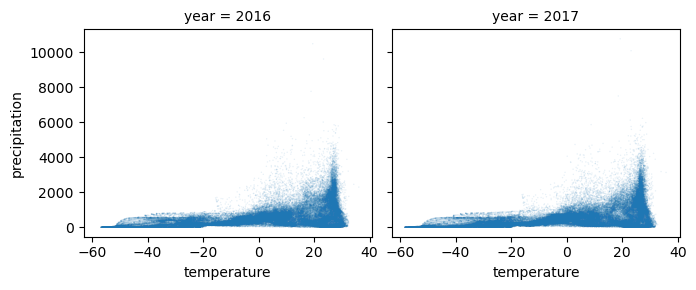

In [29]:
ds.plot.scatter(x="temperature", y="precipitation", s=1, alpha=0.1, col="year", edgecolor="none")  # try also hue="year" instead of col; requires hue_style="discrete"

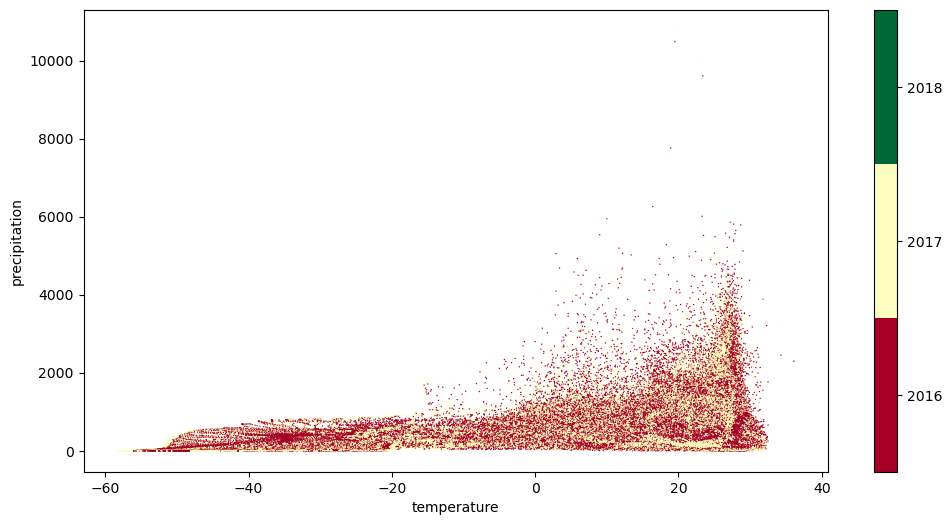

In [52]:
import matplotlib.colors as colors

# got this to work but very janky - unsure of how to fix
f, ax = plt.subplots(figsize = (12,6))
img = ds.plot.scatter(x = 'temperature', y = 'precipitation', s=1, edgecolor = 'none', hue = 'year', 
                      ax = ax, add_colorbar = False, vmax = 2018, cmap = "RdYlGn") # levels = [2016, 2017, 2018], 

# Need to set values one greater than the actual bins for some reason
f.colorbar(img, values = [2016, 2017, 2018], ticks = [2016, 2017, 2018])

### DataSet reductions

Datasets support arithmetic operations by automatically looping over all data variables and supports most of the same methods found on `xarray.DataArray`:

In [53]:
# Note that this loops over all coords - i.e., this is the mean precipitation and temperature across the entire scene for two
# years
ds.mean()

<xarray.Dataset>
Dimensions:          ()
Data variables:
    precipitation    float32 536.7
    temperature      float32 -4.093
    precipitation_m  float32 0.5367

In [55]:
# Returns the maximum value across the scene for each year
ds.max(dim=["x", "y"])

<xarray.Dataset>
Dimensions:          (year: 2)
Coordinates:
  * year             (year) int64 2016 2017
Data variables:
    precipitation    (year) float32 1.048e+04 1.077e+04
    temperature      (year) float32 36.1 35.8
    precipitation_m  (year) float32 10.48 10.77

__Note__ Using the names of the data variables (which is actually element-wise operations with DataArrays) makes a calculation very self-describing, e.g.

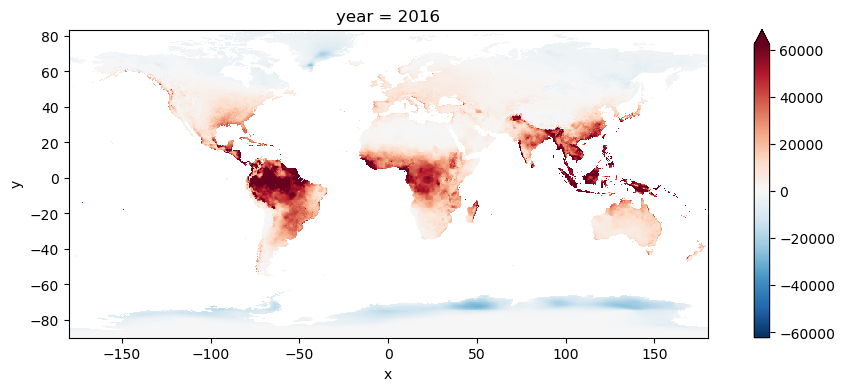

In [62]:
# obviously this calculation doesn't make any sense - just for illustrative purposes
ax = (ds["temperature"] * ds["precipitation"]).sel(year=2016).plot.imshow(robust = True, 
                                                                          interpolation = 'nearest',
                                                                          figsize = (12,4))
ax.axes.set_aspect('equal')

### Let's practice

For the next set of exercises, we use the [ERA5-Land monthly averaged data](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land-monthly-means?tab=overview), provided by the ECMWF (European Centre for Medium-Range Weather Forecasts).

> ERA5-Land is a reanalysis dataset providing a consistent view of the evolution of land variables over several decades. Reanalysis combines model data with observations from across the world into a globally complete and consistent dataset using the laws of physics. 

For these exercises, a subset of the data set focusing on Belgium has been prepared, containing the following variables:

- `sf`: Snowfall (_m of water equivalent_)
- `sp`: Surface pressure (_Pa_)
- `t2m`: 2 metre temperature (_K_)
- `tp`: Total precipitation (_m_)
- `u10`: 10 metre U wind component (_m/s_)

The dimensions are the `longitude`, `latitude` and `time`, which are each represented by a corresponding coordinate.

In [15]:
era5 = xr.open_dataset("./data/era5-land-monthly-means_example.nc") # engine="netcdf4" is here optional, since xr will guess the 
                                                                    # correct engine

# note that it clearly specifies the coords used by each data variable
era5

<xarray.Dataset>
Dimensions:    (time: 486, latitude: 21, longitude: 38)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2021-06-01
  * latitude   (latitude) float64 51.5 51.4 51.3 51.2 ... 49.8 49.7 49.6 49.5
  * longitude  (longitude) float64 2.5 2.6 2.7 2.8 2.9 ... 5.8 5.9 6.0 6.1 6.2
Data variables:
    u10        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
    sp         (time, latitude, longitude) float32 ...
    sf         (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-09-27T16:23 GRIB to CDM+CF via cfgrib-0.9.9...

To get a feeling on the spatial subset of the data set for these exercises, the following code creates a cartopy map of the average temperature with country borders added:

C:\Users\tranq\anaconda3\envs\gdal\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


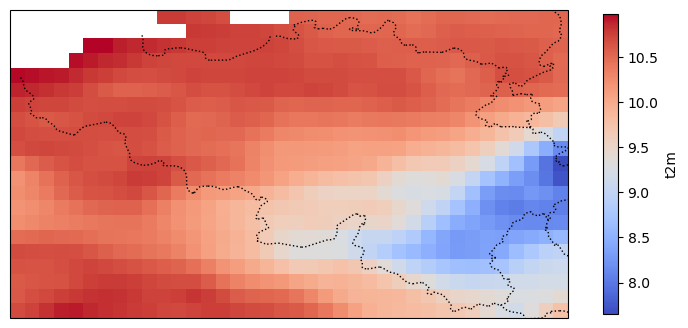

In [64]:
# Check visualization notebook for more cartopy

import cartopy
import cartopy.crs as ccrs

fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
era5_mean_temp = era5["t2m"].mean(dim="time") - 273.15 #note that t2m is surface temperature
era5_mean_temp.plot.imshow(ax=ax, cmap="coolwarm", 
                           transform=ccrs.PlateCarree(),
                           cbar_kwargs={'shrink': 0.65});

(See notebook [visualization-03-cartopy](./visualization-03-cartopy.ipynb) for more information on the usage of Cartopy)

<div class="alert alert-success">

**EXERCISE 1**:

The [short names used by ECMWF](https://confluence.ecmwf.int/display/CKB/ERA5-Land%3A+data+documentation) are not very convenient to understand. Rename the variables of the  data set according to the following mapping:
    
- `sf`: snowfall_m
- `sp`: pressure_pa
- `t2m`: temperature_k
- `tp`: precipitation_m
- `u10`: wind_ms   
    
Save the result of the mapping as the variable `era5_renamed`.

<details><summary>Hints</summary>

* Both `rename` and `rename_vars` can be used to rename the DataSet variables
* The `rename` function requires a `dict-like` input with the current names as the keys and the new names as the values. 

</details>    
    
</div>

In [16]:
# Nice, seems easier to create an initial dictionary that can be used for future code
mapping = {
    "sf": "snowfall_m",
    "sp": "pressure_pa",
    "t2m": "temperature_k",
    "tp": "precipitation_m",
    "u10": "wind_ms"
}

era5_renamed = era5.rename(mapping)

era5_renamed

<xarray.Dataset>
Dimensions:          (time: 486, latitude: 21, longitude: 38)
Coordinates:
  * time             (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2021-06-01
  * latitude         (latitude) float64 51.5 51.4 51.3 51.2 ... 49.7 49.6 49.5
  * longitude        (longitude) float64 2.5 2.6 2.7 2.8 2.9 ... 5.9 6.0 6.1 6.2
Data variables:
    wind_ms          (time, latitude, longitude) float32 ...
    temperature_k    (time, latitude, longitude) float32 ...
    pressure_pa      (time, latitude, longitude) float32 ...
    snowfall_m       (time, latitude, longitude) float32 ...
    precipitation_m  (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-09-27T16:23 GRIB to CDM+CF via cfgrib-0.9.9...

In [ ]:
# %load _solutions/12-xarray-advanced1.py
era5_renamed = era5.rename(mapping)
era5_renamed

__Note:__ _Make sure you have the variable `era5_renamed` correctly loaded for the following exercises. If not, load the solution of the previous exercise._

<div class="alert alert-success">

**EXERCISE 2**:

Start from the `era5_renamed` variable. You are used to work with temperatures defined in degrees celsius instead of Kelvin. Add a new data variable to `era5_renamed`, named `temperature_c`, by converting the `temperature_k` into degrees celsius:
    
$T_{^{\circ}C} = T_{K} - 273.15$
    
Create a histogram of the `temperature_c` to check the distribution of all the temperature valus in the data set. Use an appropriate number of bins to draw the histogram.

<details><summary>Hints</summary>

* Xarray - similar to Numpy - applies the mathematical operation element-wise, so no need for loops.
* Most plot functions work on `DataArray`, so make sure to select the variable to apply the `.plot.hist()`.
* One can define the number of bins using the `bins` parameter in the `hist` method.

</details>    
    
</div>

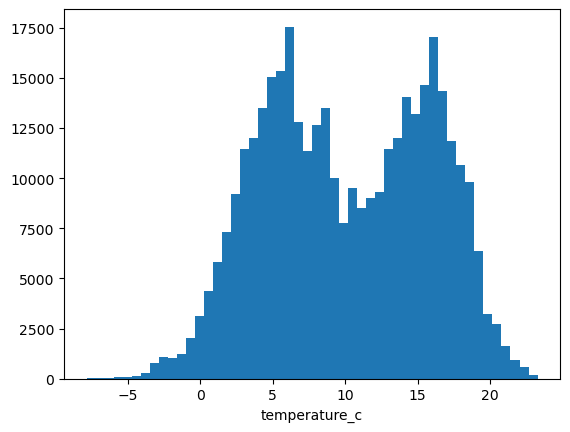

In [75]:
era5_renamed['temperature_c'] = era5_renamed['temperature_k'] - 273.15

# Note that plot.hist() only works with DataArray - you must extract the appropriate arrays
# multiple histograms probably need to use plt.subplots()
era5_renamed['temperature_c'].plot.hist(bins = 50);

In [ ]:
# %load _solutions/12-xarray-advanced2.py
era5_renamed["temperature_c"] = era5_renamed["temperature_k"] - 273.15

In [ ]:
# %load _solutions/12-xarray-advanced3.py
era5_renamed["temperature_c"].plot.hist(bins=50);

<div class="alert alert-success">

**EXERCISE 3**:

Calculate the total snowfall of the entire region of the dataset in function of time and create a line plot showing total snowfall in the y-axis and time in the x-axis.

<details><summary>Hints</summary>

* You need to calculate the total (`sum`) snowfall (`snowfall_m`) in function of time, i.e. aggregate over both the `longitude` and `latitude` dimensions (`dim=["latitude", "longitude"]`).
* As the result is a DataArray with a single dimension, the default `plot` will show a line, but you can be more explicit by saying `.plot.line()`.

</details>    
    
</div>

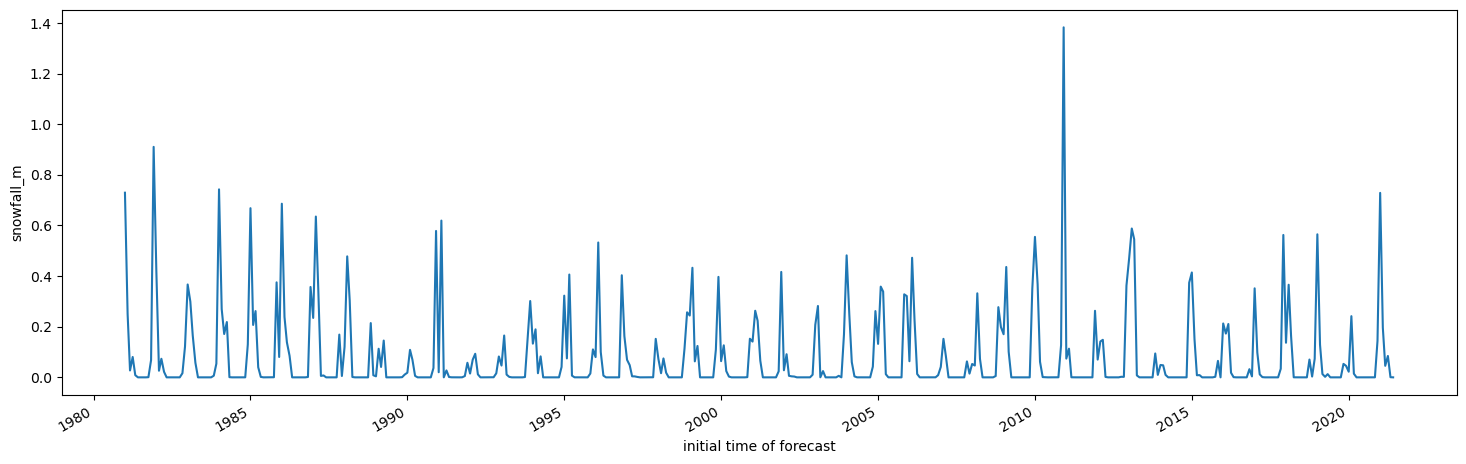

In [83]:
era5_renamed['snowfall_m'].sum(dim = ['latitude', 'longitude']).plot.line(x = 'time', figsize = (18,5));

In [ ]:
# %load _solutions/12-xarray-advanced4.py
era5_renamed["snowfall_m"].sum(dim=["latitude", "longitude"]).plot.line(figsize=(18, 5))

<div class="alert alert-success">

**EXERCISE 4**:

The speed of sound is linearly dependent on temperature:
    
$v = 331.5 + (0.6 \cdot T)$
    
with $v$ the speed of sound and $T$ the temperature in degrees celsius.    
    
Add a new variable to the `era5_renamed` data set, called `speed_of_sound_m_s`, that calculates for each location and each time stamp in the data set the temperature corrected speed of sound.
    
Create a scatter plot to control the (linear) relationship you just calculated by comparing all the `speed_of_sound_m_s` and `temperature_c` data points in the data set.

<details><summary>Hints</summary>

* Creating a new variable is similar to GeoPandas/Pandas/dictionaries, `ds["MY_NEW_VAR"] = ...`.
* Remember, calculations are __element-wise__ just as in Numpy/Pandas; so no need for loops. The numbers (331.5, 0.6) are broadcasted to all elements in the data set to do the calculation.
* To compare two variables in a data set visually, `plot.scatter()` it is.

</details>    
    
</div>

In [84]:
era5_renamed['speed_of_sound_ms'] = 331.5 + (0.6 * era5_renamed['temperature_c'])

era5_renamed

<xarray.Dataset>
Dimensions:            (time: 486, latitude: 21, longitude: 38)
Coordinates:
  * time               (time) datetime64[ns] 1981-01-01 ... 2021-06-01
  * latitude           (latitude) float64 51.5 51.4 51.3 51.2 ... 49.7 49.6 49.5
  * longitude          (longitude) float64 2.5 2.6 2.7 2.8 ... 5.9 6.0 6.1 6.2
Data variables:
    wind_ms            (time, latitude, longitude) float32 ...
    temperature_k      (time, latitude, longitude) float32 nan nan ... 291.7
    pressure_pa        (time, latitude, longitude) float32 ...
    snowfall_m         (time, latitude, longitude) float32 nan nan ... 0.0 0.0
    precipitation_m    (time, latitude, longitude) float32 ...
    temperature_c      (time, latitude, longitude) float32 nan nan ... 18.59
    speed_of_sound_ms  (time, latitude, longitude) float32 nan nan ... 342.7
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-09-27T16:23 GRIB to CDM+CF via cfgrib-0.9.9...

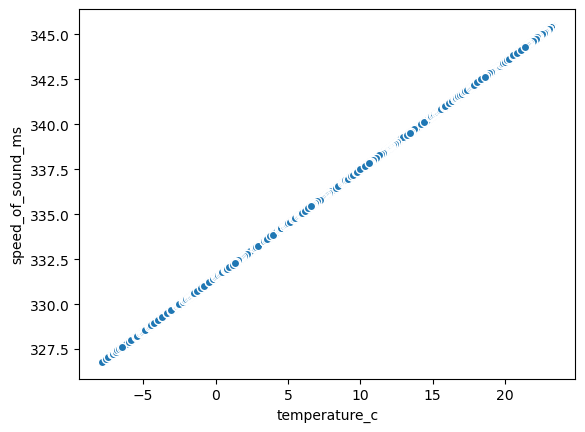

In [88]:
# linear relationship as expected from definition
era5_renamed.plot.scatter(x = 'temperature_c', y = 'speed_of_sound_ms');

In [ ]:
# %load _solutions/12-xarray-advanced5.py
era5_renamed["speed_of_sound_m_s"] = 331.5 + (0.6*era5_renamed["temperature_c"])

In [ ]:
# %load _solutions/12-xarray-advanced6.py
era5_renamed.plot.scatter(x="temperature_c", y="speed_of_sound_m_s")

## Working with time series

Let's start again from the ERA5 data set we worked with in the previous exercises, and rename the variables for convenience:

In [91]:
era5 = xr.open_dataset("./data/era5-land-monthly-means_example.nc")
mapping = {
    "sf": "snowfall_m",
    "sp": "pressure_pa",
    "t2m": "temperature_k",
    "tp": "precipitation_m",
    "u10": "wind_ms"
}
era5_renamed = era5.rename(mapping)
era5_renamed

<xarray.Dataset>
Dimensions:          (time: 486, latitude: 21, longitude: 38)
Coordinates:
  * time             (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2021-06-01
  * latitude         (latitude) float64 51.5 51.4 51.3 51.2 ... 49.7 49.6 49.5
  * longitude        (longitude) float64 2.5 2.6 2.7 2.8 2.9 ... 5.9 6.0 6.1 6.2
Data variables:
    wind_ms          (time, latitude, longitude) float32 ...
    temperature_k    (time, latitude, longitude) float32 ...
    pressure_pa      (time, latitude, longitude) float32 ...
    snowfall_m       (time, latitude, longitude) float32 ...
    precipitation_m  (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-09-27T16:23 GRIB to CDM+CF via cfgrib-0.9.9...

Apart from the different coordinates, the data set also contains a `time` dimension. xarray borrows the indexing machinery from Pandas, also for datetime coordinates:

In [92]:
era5_renamed.time

<xarray.DataArray 'time' (time: 486)>
array(['1981-01-01T00:00:00.000000000', '1981-02-01T00:00:00.000000000',
       '1981-03-01T00:00:00.000000000', ..., '2021-04-01T00:00:00.000000000',
       '2021-05-01T00:00:00.000000000', '2021-06-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2021-06-01
Attributes:
    long_name:      initial time of forecast
    standard_name:  forecast_reference_time

In [95]:
era5_renamed.time.dtype

dtype('<M8[ns]')

In [96]:
# Note that the dtypes are the same
np.dtype('datetime64[ns]') == np.dtype('<M8[ns]')

True

With a DateTime-aware index (see `datetime64[ns]` as dtype), selecting dates can be done using the string representation, e.g.

In [97]:
# Smart indexing
era5_renamed.sel(time="2002").time 

<xarray.DataArray 'time' (time: 12)>
array(['2002-01-01T00:00:00.000000000', '2002-02-01T00:00:00.000000000',
       '2002-03-01T00:00:00.000000000', '2002-04-01T00:00:00.000000000',
       '2002-05-01T00:00:00.000000000', '2002-06-01T00:00:00.000000000',
       '2002-07-01T00:00:00.000000000', '2002-08-01T00:00:00.000000000',
       '2002-09-01T00:00:00.000000000', '2002-10-01T00:00:00.000000000',
       '2002-11-01T00:00:00.000000000', '2002-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2002-01-01 2002-02-01 ... 2002-12-01
Attributes:
    long_name:      initial time of forecast
    standard_name:  forecast_reference_time

In [98]:
# It seems like it uses smart indexing - automatically parses year-month combinations
# .is_month_start <- use to identify the first of each month
era5_renamed.sel(time=slice("2001-05", "2002-08")).time

<xarray.DataArray 'time' (time: 16)>
array(['2001-05-01T00:00:00.000000000', '2001-06-01T00:00:00.000000000',
       '2001-07-01T00:00:00.000000000', '2001-08-01T00:00:00.000000000',
       '2001-09-01T00:00:00.000000000', '2001-10-01T00:00:00.000000000',
       '2001-11-01T00:00:00.000000000', '2001-12-01T00:00:00.000000000',
       '2002-01-01T00:00:00.000000000', '2002-02-01T00:00:00.000000000',
       '2002-03-01T00:00:00.000000000', '2002-04-01T00:00:00.000000000',
       '2002-05-01T00:00:00.000000000', '2002-06-01T00:00:00.000000000',
       '2002-07-01T00:00:00.000000000', '2002-08-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2001-05-01 2001-06-01 ... 2002-08-01
Attributes:
    long_name:      initial time of forecast
    standard_name:  forecast_reference_time

And you can access the datetime components, e.g. "year", "month",..., "dayofyear", "week", "dayofweek",... but also "season". Do not forget to use the `.dt`-accessor to access these components:

In [99]:
# Seasonal selection - requires dt accessor
era5_renamed["time"].dt.season

<xarray.DataArray 'season' (time: 486)>
array(['DJF', 'DJF', 'MAM', ..., 'MAM', 'MAM', 'JJA'], dtype=object)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2021-06-01
Attributes:
    long_name:      initial time of forecast
    standard_name:  forecast_reference_time

In [101]:
# Select first of every month (.is_month_start returns a boolean np. array)

era5_renamed['time'][era5_renamed["time"].dt.is_month_start]

<xarray.DataArray 'time' (time: 486)>
array(['1981-01-01T00:00:00.000000000', '1981-02-01T00:00:00.000000000',
       '1981-03-01T00:00:00.000000000', ..., '2021-04-01T00:00:00.000000000',
       '2021-05-01T00:00:00.000000000', '2021-06-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2021-06-01
Attributes:
    long_name:      initial time of forecast
    standard_name:  forecast_reference_time

In [103]:
# Get data on the second of every month
# NB returns null since the dataset only contains first of every month
era5_renamed['time'][era5_renamed["time"].dt.day == 2]

<xarray.DataArray 'time' (time: 0)>
array([], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 
Attributes:
    long_name:      initial time of forecast
    standard_name:  forecast_reference_time

Xarray contains some more powerful functionalities to work with time series, e.g. `groupby`, `resample` and `rolling`. All have a similar syntax as Pandas/GeoPandas, but applied on an N-dimensional array instead of a DataFrame.

### split-apply-combine, aka `groupby`

If we are interested in the _average over time_ for each of the levels, we can use a reducton function to get the averages of each of the variables at the same time:

In [113]:
# Returns average parameter in each pixel over all time datapoints
era5_renamed.mean(dim=["time"])

<xarray.Dataset>
Dimensions:          (latitude: 21, longitude: 38)
Coordinates:
  * latitude         (latitude) float64 51.5 51.4 51.3 51.2 ... 49.7 49.6 49.5
  * longitude        (longitude) float64 2.5 2.6 2.7 2.8 2.9 ... 5.9 6.0 6.1 6.2
Data variables:
    wind_ms          (latitude, longitude) float32 nan nan nan ... 0.677 0.6613
    temperature_k    (latitude, longitude) float32 nan nan nan ... 282.7 282.9
    pressure_pa      (latitude, longitude) float32 nan nan ... 9.874e+04
    snowfall_m       (latitude, longitude) float32 nan nan ... 0.0001283
    precipitation_m  (latitude, longitude) float32 nan nan ... 0.002439 0.002376

But if we wanted the _average for each month of the year_ per level, we would first have to __split__ the data set in a group for each month of the year, __apply__ the average function on each of the months and __combine__ the data again. 

We already learned about the [split-apply-combine](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html) approach when using Pandas. The syntax of Xarray’s groupby is almost identical to Pandas!

First, extract the month of the year (1 -> 12) from each of the time coordinate/dimension:

In [114]:
era5_renamed["time"].dt.month  # The coordinates is a Pandas datetime index

<xarray.DataArray 'month' (time: 486)>
array([1, 2, 3, ..., 4, 5, 6], dtype=int64)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2021-06-01
Attributes:
    long_name:      initial time of forecast
    standard_name:  forecast_reference_time

We can use this array in a `groupby` operation:

In [115]:
# Groups data by month - returns groupby object
# Note that this takes the dt.month object (i.e., the datetime index) and groups era5_renamed according to that index
era5_renamed.groupby(era5_renamed["time"].dt.month)

DatasetGroupBy, grouped over 'month'
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

_split the data in (12) groups where each element is grouped according to the month it belongs to._

__Note:__ Xarray also offers a more concise syntax when the variable you're grouping on is already present in the dataset. The following statement is identical to the previous line:

In [ ]:
# Automatically group by month if the data variable is already present
era5_renamed.groupby("time.month")

Next, we apply an aggregation function _for each of the months_ over the `time` dimension in order to end up with: _for each month of the year, the average (over time) for each of the levels_:

In [118]:
# Mean is the aggregation function we use

# Return is a "month" coord which contains the average monthly value across all years in the dataset at each lat/long coordinate
era5_month = era5_renamed.groupby("time.month").mean()

era5_month

<xarray.Dataset>
Dimensions:          (latitude: 21, longitude: 38, month: 12)
Coordinates:
  * latitude         (latitude) float64 51.5 51.4 51.3 51.2 ... 49.7 49.6 49.5
  * longitude        (longitude) float64 2.5 2.6 2.7 2.8 2.9 ... 5.9 6.0 6.1 6.2
  * month            (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    wind_ms          (month, latitude, longitude) float32 nan nan ... 0.9864
    temperature_k    (month, latitude, longitude) float32 nan nan ... 275.9
    pressure_pa      (month, latitude, longitude) float32 nan nan ... 9.88e+04
    snowfall_m       (month, latitude, longitude) float32 nan nan ... 0.0004173
    precipitation_m  (month, latitude, longitude) float32 nan nan ... 0.0029
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-09-27T16:23 GRIB to CDM+CF via cfgrib-0.9.9...

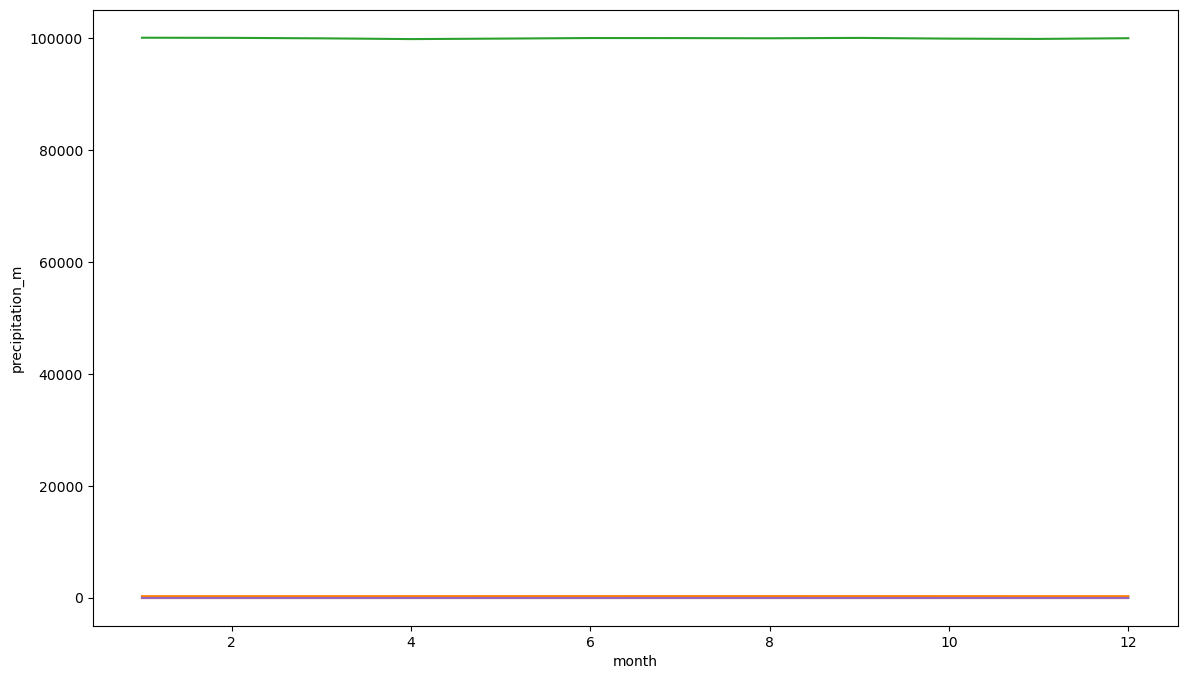

In [130]:
# Practice graphing
# It seems like you need to use a for loop to put it all on one graph...
f, ax = plt.subplots(figsize = (14,8))

for variable in era5_month.data_vars:
    era5_month[variable].mean(dim = ['latitude', 'longitude']).plot.line(x = 'month', ax = ax)
    
# individual plot
# era5_month['temperature_k'].mean(dim = ['latitude', 'longitude']).plot.line(x = 'month')

In [126]:
era5_month.data_vars

Data variables:
    wind_ms          (month, latitude, longitude) float32 nan nan ... 0.9864
    temperature_k    (month, latitude, longitude) float32 nan nan ... 275.9
    pressure_pa      (month, latitude, longitude) float32 nan nan ... 9.88e+04
    snowfall_m       (month, latitude, longitude) float32 nan nan ... 0.0004173
    precipitation_m  (month, latitude, longitude) float32 nan nan ... 0.0029

The resulting dimension month contains the 12 groups on which the data set was split up.

<img align="center" src="../img/pandas/06_groupby1.svg">

<div class="alert alert-info" style="font-size:120%">

**REMEMBER**: <br>

The `groupby` method splits the data set in groups, applies some function _on each of the groups_ and combines again the results of each of the groups. It is not limited to time series data, but can be used in any situation where the data can be split up by a categorical variable. 

</div>

### resample/rolling

Another (alike) operation - specifically for time series data - is to `resample` the data to another time-aggregation. For example, resample to monthly (`4M`) or yearly (`1Y`) median values:

In [17]:
# Resamples the data to be yearly
era5_renamed.resample(time="1Y").median()  # 4M

<xarray.Dataset>
Dimensions:          (latitude: 21, longitude: 38, time: 41)
Coordinates:
  * latitude         (latitude) float64 51.5 51.4 51.3 51.2 ... 49.7 49.6 49.5
  * longitude        (longitude) float64 2.5 2.6 2.7 2.8 2.9 ... 5.9 6.0 6.1 6.2
  * time             (time) datetime64[ns] 1981-12-31 1982-12-31 ... 2021-12-31
Data variables:
    wind_ms          (time, latitude, longitude) float32 nan nan ... 0.5049
    temperature_k    (time, latitude, longitude) float32 nan nan ... 279.0 279.2
    pressure_pa      (time, latitude, longitude) float32 nan nan ... 9.882e+04
    snowfall_m       (time, latitude, longitude) float32 nan nan ... 6.312e-05
    precipitation_m  (time, latitude, longitude) float32 nan nan ... 0.002751
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-09-27T16:23 GRIB to CDM+CF via cfgrib-0.9.9...

In [18]:
# Resamples the data into 4 month intervals
display(era5_renamed.resample(time="4M").median()) # 4M

# Check values of the time coord to confirm
era5_renamed.resample(time="4M").median().time

<xarray.Dataset>
Dimensions:          (latitude: 21, longitude: 38, time: 123)
Coordinates:
  * latitude         (latitude) float64 51.5 51.4 51.3 51.2 ... 49.7 49.6 49.5
  * longitude        (longitude) float64 2.5 2.6 2.7 2.8 2.9 ... 5.9 6.0 6.1 6.2
  * time             (time) datetime64[ns] 1981-01-31 1981-05-31 ... 2021-09-30
Data variables:
    wind_ms          (time, latitude, longitude) float32 nan nan ... 0.09181
    temperature_k    (time, latitude, longitude) float32 nan nan ... 291.5 291.7
    pressure_pa      (time, latitude, longitude) float32 nan nan ... 9.881e+04
    snowfall_m       (time, latitude, longitude) float32 nan nan nan ... 0.0 0.0
    precipitation_m  (time, latitude, longitude) float32 nan nan ... 0.003557
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-09-27T16:23 GRIB to CDM+CF via cfgrib-0.9.9...

<xarray.DataArray 'time' (time: 123)>
array(['1981-01-31T00:00:00.000000000', '1981-05-31T00:00:00.000000000',
       '1981-09-30T00:00:00.000000000', '1982-01-31T00:00:00.000000000',
       '1982-05-31T00:00:00.000000000', '1982-09-30T00:00:00.000000000',
       '1983-01-31T00:00:00.000000000', '1983-05-31T00:00:00.000000000',
       '1983-09-30T00:00:00.000000000', '1984-01-31T00:00:00.000000000',
       '1984-05-31T00:00:00.000000000', '1984-09-30T00:00:00.000000000',
       '1985-01-31T00:00:00.000000000', '1985-05-31T00:00:00.000000000',
       '1985-09-30T00:00:00.000000000', '1986-01-31T00:00:00.000000000',
       '1986-05-31T00:00:00.000000000', '1986-09-30T00:00:00.000000000',
       '1987-01-31T00:00:00.000000000', '1987-05-31T00:00:00.000000000',
       '1987-09-30T00:00:00.000000000', '1988-01-31T00:00:00.000000000',
       '1988-05-31T00:00:00.000000000', '1988-09-30T00:00:00.000000000',
       '1989-01-31T00:00:00.000000000', '1989-05-31T00:00:00.000000000',
       '1989-09-30T00:00:00.000000000', '1990-01-31T00:00:00.000000000',
       '1990-05-31T00:00:00.000000000', '1990-09-30T00:00:00.000000000',
       '1991-01-31T00:00:00.000000000', '1991-05-31T00:00:00.000000000',
       '1991-09-30T00:00:00.000000000', '1992-01-31T00:00:00.000000000',
       '1992-05-31T00:00:00.000000000', '1992-09-30T00:00:00.000000000',
       '1993-01-31T00:00:00.000000000', '1993-05-31T00:00:00.000000000',
       '1993-09-30T00:00:00.000000000', '1994-01-31T00:00:00.000000000',
       '1994-05-31T00:00:00.000000000', '1994-09-30T00:00:00.000000000',
       '1995-01-31T00:00:00.000000000', '1995-05-31T00:00:00.000000000',
       '1995-09-30T00:00:00.000000000', '1996-01-31T00:00:00.000000000',
       '1996-05-31T00:00:00.000000000', '1996-09-30T00:00:00.000000000',
       '1997-01-31T00:00:00.000000000', '1997-05-31T00:00:00.000000000',
       '1997-09-30T00:00:00.000000000', '1998-01-31T00:00:00.000000000',
       '1998-05-31T00:00:00.000000000', '1998-09-30T00:00:00.000000000',
       '1999-01-31T00:00:00.000000000', '1999-05-31T00:00:00.000000000',
       '1999-09-30T00:00:00.000000000', '2000-01-31T00:00:00.000000000',
       '2000-05-31T00:00:00.000000000', '2000-09-30T00:00:00.000000000',
       '2001-01-31T00:00:00.000000000', '2001-05-31T00:00:00.000000000',
       '2001-09-30T00:00:00.000000000', '2002-01-31T00:00:00.000000000',
       '2002-05-31T00:00:00.000000000', '2002-09-30T00:00:00.000000000',
       '2003-01-31T00:00:00.000000000', '2003-05-31T00:00:00.000000000',
       '2003-09-30T00:00:00.000000000', '2004-01-31T00:00:00.000000000',
       '2004-05-31T00:00:00.000000000', '2004-09-30T00:00:00.000000000',
       '2005-01-31T00:00:00.000000000', '2005-05-31T00:00:00.000000000',
       '2005-09-30T00:00:00.000000000', '2006-01-31T00:00:00.000000000',
       '2006-05-31T00:00:00.000000000', '2006-09-30T00:00:00.000000000',
       '2007-01-31T00:00:00.000000000', '2007-05-31T00:00:00.000000000',
       '2007-09-30T00:00:00.000000000', '2008-01-31T00:00:00.000000000',
       '2008-05-31T00:00:00.000000000', '2008-09-30T00:00:00.000000000',
       '2009-01-31T00:00:00.000000000', '2009-05-31T00:00:00.000000000',
       '2009-09-30T00:00:00.000000000', '2010-01-31T00:00:00.000000000',
       '2010-05-31T00:00:00.000000000', '2010-09-30T00:00:00.000000000',
       '2011-01-31T00:00:00.000000000', '2011-05-31T00:00:00.000000000',
       '2011-09-30T00:00:00.000000000', '2012-01-31T00:00:00.000000000',
       '2012-05-31T00:00:00.000000000', '2012-09-30T00:00:00.000000000',
       '2013-01-31T00:00:00.000000000', '2013-05-31T00:00:00.000000000',
       '2013-09-30T00:00:00.000000000', '2014-01-31T00:00:00.000000000',
       '2014-05-31T00:00:00.000000000', '2014-09-30T00:00:00.000000000',
       '2015-01-31T00:00:00.000000000', '2015-05-31T00:00:00.000000000',
       '2015-09-30T00:00:00.000000000', '2016-01-31T00:00:00.000000000',
       '2016-05-31T00:00:00.000000000', '2016-09-30T00:00:00.000000000',
       '2017-01-31T0

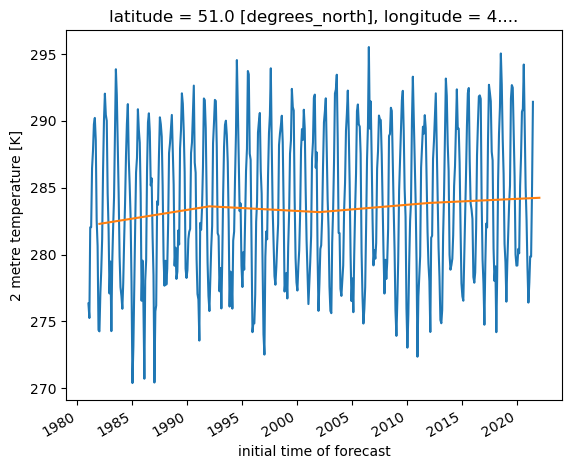

In [19]:
# monthly temperature values compared to decade-resampled temperature values
era5_renamed["temperature_k"].sel(latitude=51., longitude=4., method="nearest").plot.line(x="time");
era5_renamed["temperature_k"].sel(latitude=51., longitude=4., method="nearest").resample(time="10Y").median().plot.line(x="time");

A similar, but different functionality is `rolling` to calculate rolling window aggregates:

In [23]:
# rolls on the time coord with a window spacing of 12 "units" or "data points"
# center = True means that it takes the median at the centre of the 12 units
era5_renamed.rolling(time=12, center=True).median()

<xarray.Dataset>
Dimensions:          (time: 486, latitude: 21, longitude: 38)
Coordinates:
  * time             (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2021-06-01
  * latitude         (latitude) float64 51.5 51.4 51.3 51.2 ... 49.7 49.6 49.5
  * longitude        (longitude) float64 2.5 2.6 2.7 2.8 2.9 ... 5.9 6.0 6.1 6.2
Data variables:
    wind_ms          (time, latitude, longitude) float32 nan nan nan ... nan nan
    temperature_k    (time, latitude, longitude) float32 nan nan nan ... nan nan
    pressure_pa      (time, latitude, longitude) float32 nan nan nan ... nan nan
    snowfall_m       (time, latitude, longitude) float32 nan nan nan ... nan nan
    precipitation_m  (time, latitude, longitude) float32 nan nan nan ... nan nan
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-09-27T16:23 GRIB to CDM+CF via cfgrib-0.9.9...

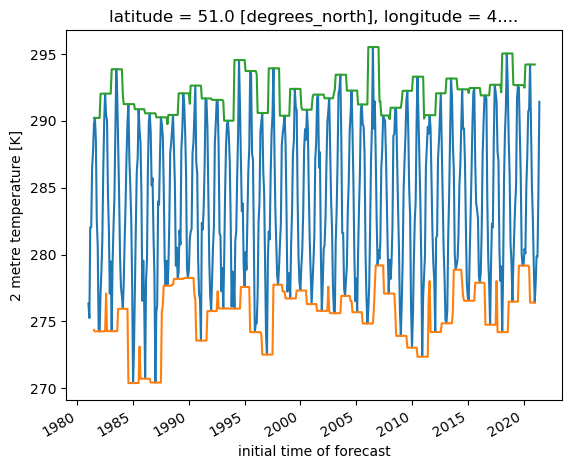

In [25]:
era5_renamed["temperature_k"].sel(latitude=51., longitude=4., method="nearest").plot.line()
era5_renamed["temperature_k"].sel(latitude=51., longitude=4., method="nearest").rolling(time=12, center=True).min().plot.line()
era5_renamed["temperature_k"].sel(latitude=51., longitude=4., method="nearest").rolling(time=12, center=True).max().plot.line()

<div class="alert alert-info" style="font-size:120%">

**REMEMBER**: <br>

The [xarray `groupby`](http://xarray.pydata.org/en/stable/groupby.html) with the same syntax as Pandas implements the __split-apply-combine__ strategy. Also [`resample`](http://xarray.pydata.org/en/stable/time-series.html#resampling-and-grouped-operations) and [`rolling`](http://xarray.pydata.org/en/stable/computation.html?highlight=rolling#rolling-window-operations) are available in xarray.
    
__Note:__ Xarray adds a [`groupby_bins`](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.groupby_bins.html#xarray.Dataset.groupby_bins) convenience function for binned groups (instead of each value).

</div>

In [142]:
# Example of groupby bins
# This groups the groupby variable into the specified bins rather than the individual values

# Check the ranges in the new month_bins coord:
# Parentheses, ( or ), are used to signify that an endpoint value is not included, called exclusive.
# Brackets, [ or ], are used to indicate that an endpoint value is included, called inclusive.
era5_renamed.groupby_bins('time.month', [0, 3, 10, 12]).mean()

<xarray.Dataset>
Dimensions:          (latitude: 21, longitude: 38, month_bins: 3)
Coordinates:
  * latitude         (latitude) float64 51.5 51.4 51.3 51.2 ... 49.7 49.6 49.5
  * longitude        (longitude) float64 2.5 2.6 2.7 2.8 2.9 ... 5.9 6.0 6.1 6.2
  * month_bins       (month_bins) object (0, 3] (3, 10] (10, 12]
Data variables:
    wind_ms          (month_bins, latitude, longitude) float32 nan ... 0.8113
    temperature_k    (month_bins, latitude, longitude) float32 nan nan ... 277.3
    pressure_pa      (month_bins, latitude, longitude) float32 nan ... 9.874e+04
    snowfall_m       (month_bins, latitude, longitude) float32 nan ... 0.0002781
    precipitation_m  (month_bins, latitude, longitude) float32 nan ... 0.002672
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-09-27T16:23 GRIB to CDM+CF via cfgrib-0.9.9...

### Let's practice

Run this cell before doing the exercises, so the starting point is again the `era5_renamed` data set:

In [26]:
era5 = xr.open_dataset("./data/era5-land-monthly-means_example.nc")
mapping = {
    "sf": "snowfall_m",
    "sp": "pressure_pa",
    "t2m": "temperature_k",
    "tp": "precipitation_m",
    "u10": "wind_ms"
}
era5_renamed = era5.rename(mapping)

<div class="alert alert-success">

**EXERCISE 5**:

Select the pressure data for the pixel closest to the center of Ghent (lat: -51.05, lon: 3.71) and assign the outcome to a new variable `ghent_pressure`.

Define a Matplotlib `Figure` and `Axes` (respectively named `fig, ax`) and use it to create a plot that combines the yearly average of the pressure data in Gent with the monthly pressure data as function of time for that same pixel as line plots. Change the name of the y-label to `'Pressure (Pa)'` and the title of the plot to `'Pressure (Pa) in Ghent (at -51.05, 3.71)'` (see notebook [visualization-01-matplotlib.ipynb](./visualization-01-matplotlib.ipynb#An-small-cheat-sheet-reference-for-some-common-elements) for more information)

<details><summary>Hints</summary>
    
* For the yearly average, actually both `resample(time="Y")` as `groupby("time.year")` can be used. The main difference is the returned dimension after the grouping: `resample` returns a DateTimeIndex, whereas `groupby` returns a dimension called `year` and no longer contains the DateTimeIndex. To combine the data with other time series data, using the DateTimeIndex is preferred (i.e. `resample`). 
* `fig, ax = plt.subplots()` is a useful shortcut to prepare a Matplotlib Figure. You can add a label `set_label()` and title `set_title()` to the `axes` object.

</details>    
    
</div>

In [27]:
# note how you simply call the actual name of the coord without quotations
gent_pressure = era5_renamed['pressure_pa'].sel(latitude = 51.05, longitude = 3.71, method = 'nearest')

gent_pressure

<xarray.DataArray 'pressure_pa' (time: 486)>
[486 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2021-06-01
    latitude   float64 51.1
    longitude  float64 3.7
Attributes: (12/31)
    GRIB_paramId:                             134
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      798
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avgid
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               Pa
    long_name:                                Surface pressure
    units:                                    Pa
    standard_name:                            surface_air_pressure
    coordinates:                              number time step surface latitu...

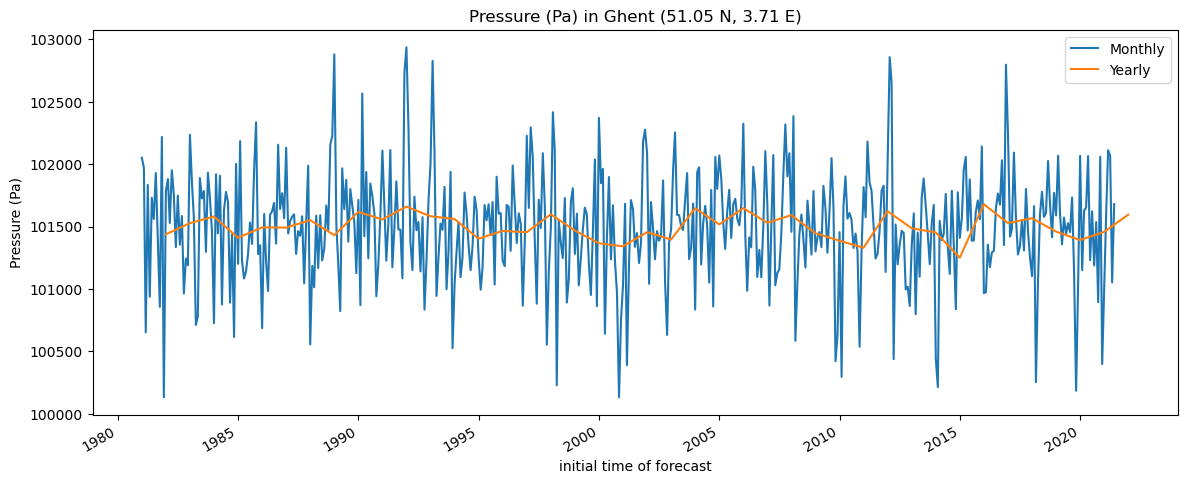

In [160]:
f, ax = plt.subplots(figsize = (14,5))

# Monthly pressure
gent_pressure.plot.line(x = 'time', ax = ax, label = "Monthly")

# Average Yearly pressure
gent_pressure.resample(time = '1Y').mean().plot.line(x = 'time', ax = ax, label = "Yearly")
ax.legend()
ax.set_ylabel('Pressure (Pa)')
ax.set_title('Pressure (Pa) in Ghent (51.05 N, 3.71 E)');

In [155]:
gent_pressure.resample(time = '1Y')

DataArrayResample, grouped over '__resample_dim__'
41 groups with labels 1981-12-31, ..., 2021-12-31.

In [ ]:
# %load _solutions/12-xarray-advanced7.py
ghent_pressure = era5_renamed.sel(latitude=51.05, longitude=3.71, method="nearest")["pressure_pa"]

fig, ax = plt.subplots(figsize=(18, 6))
ghent_pressure.plot.line(ax=ax)
ghent_pressure.resample(time="Y").mean().plot.line(ax=ax)

ax.set_ylabel('Pressure (Pa)')
ax.set_title('Pressure (Pa) in Ghent (-51.05, 3.71)')

<div class="alert alert-success">

**EXERCISE 6**:
    
Select the precipitation data for the pixel closest to the center of Ghent (lat: -51.05, lon: 3.71) and assign the outcome to a new variable `ghent_precipitation`.
    
For the Ghent pixel, calculate the maximal precipitation _for each month of the year_ (1 -> 12) and convert it to mm precipitation.
    
To make a bar-chart (not supported in xarray) of the maximal precipitation for each month of the year, convert the output to a Pandas DataFrame using the `to_dataframe()` method and create a horizontal bar chart with the month in the y-axis and the maximal precipitation in the x-axis. Feel free to improve the axis labels.

<details><summary>Hints</summary>
    
* You need to group based on the month of the data point, hence `groupby("...")` with `time` as an existing dimension, the `time.month` shortcut to get the corresponding month will work.
* Plotting in Pandas is very similar to xarray, use `.plot.barh()` to create a horizontal bar chart.

</details>    
    
</div>

In [161]:
# note how you simply call the actual name of the coord without quotations
ghent_precipitation = era5_renamed['precipitation_m'].sel(latitude = 51.05, longitude = 3.71, method = 'nearest')

ghent_precipitation

<xarray.DataArray 'precipitation_m' (time: 486)>
array([0.002687, 0.001198, 0.004014, ..., 0.001367, 0.003465, 0.003911],
      dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2021-06-01
    latitude   float64 51.1
    longitude  float64 3.7
Attributes: (12/31)
    GRIB_paramId:                             228
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      798
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avgas
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               m
    long_name:                                Total precipitation
    units:                                    m
    standard_name:                            unknown
    coordinates:                              number time step surface latitu...

In [198]:
max_monthly_ppt = ghent_precipitation.groupby("time.month").max() * 1000

max_monthly_ppt

<xarray.DataArray 'precipitation_m' (month: 12)>
array([4.25121095, 4.12320253, 4.08065971, 4.32259869, 4.61948104,
       4.36679414, 4.95026633, 5.6688427 , 5.12341689, 4.3623778 ,
       4.29330021, 4.80405474])
Coordinates:
    latitude   float64 51.1
    longitude  float64 3.7
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

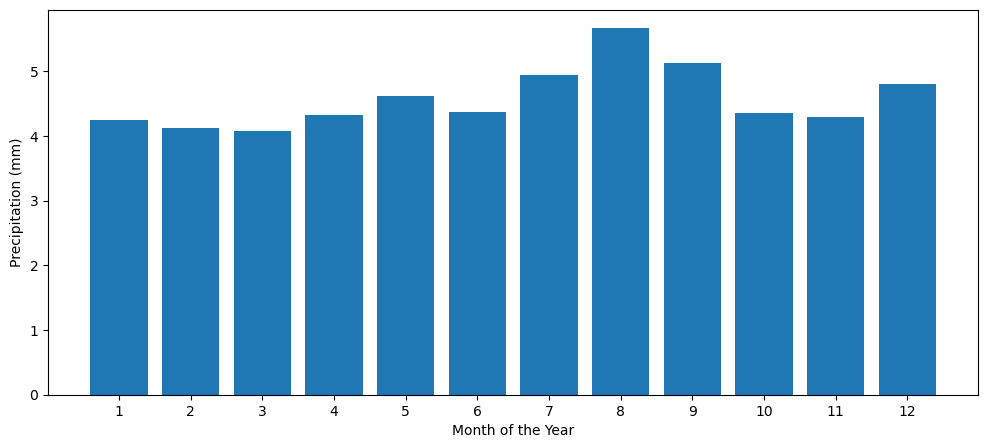

In [200]:
f, ax = plt.subplots(figsize = (12,5))

ax.bar(max_monthly_ppt.month, max_monthly_ppt.values)

ax.set_xlabel("Month of the Year")
ax.set_ylabel("Precipitation (mm)")

# manually set xticks
ax.set_xticks(range(1,13));

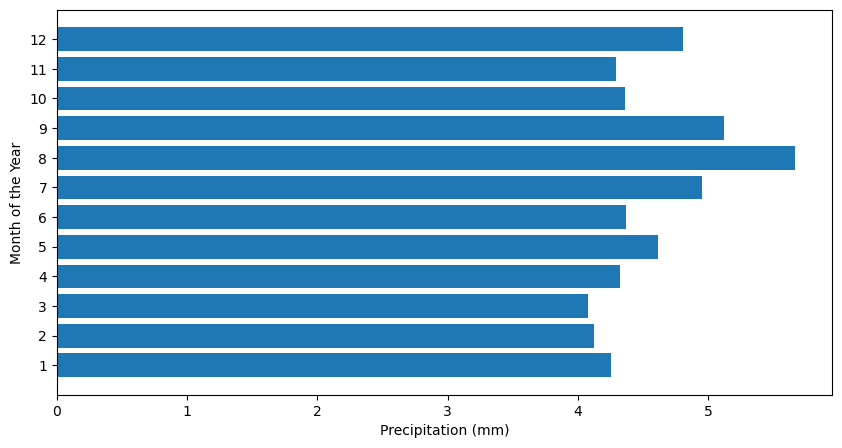

In [201]:
f, ax = plt.subplots(figsize = (10,5))

# Set x-tick labels and height
ax.barh(max_monthly_ppt.month, max_monthly_ppt.values)

ax.set_xlabel("Precipitation (mm)")
ax.set_ylabel("Month of the Year")
# manually set xticks
ax.set_yticks(range(1,13));

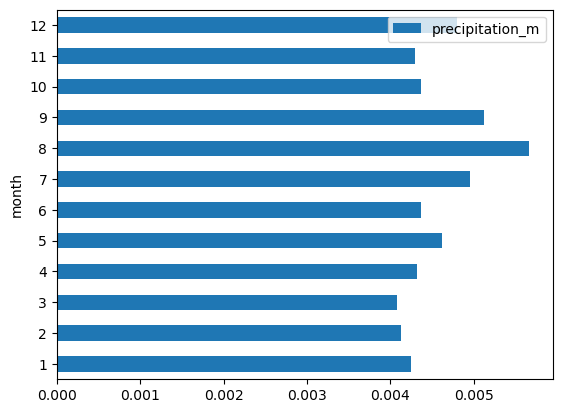

In [184]:
# Requested solution 
monthly_ppt_df = max_monthly_ppt.to_dataframe().reset_index()

# monthly_ppt_df

ax = monthly_ppt_df.plot.barh(y = 'precipitation_m', x = 'month') #

Text(0, 0.5, 'Month of the year')

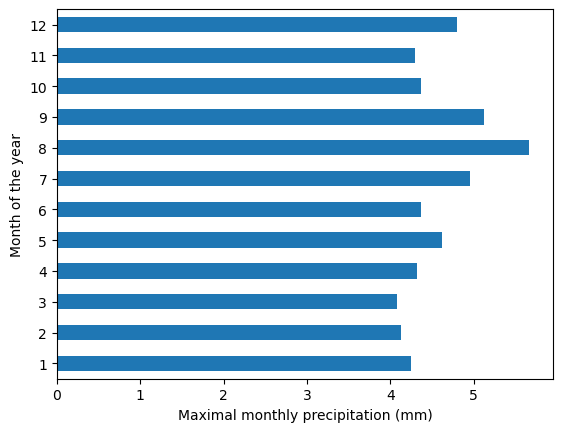

In [185]:
# %load _solutions/12-xarray-advanced8.py
ghent_precipitation = era5_renamed.sel(latitude=51.05, longitude=3.71, method="nearest")["precipitation_m"]
ghent_precipitation_month_max = ghent_precipitation.groupby("time.month").max()*1000

fig, ax = plt.subplots()
ghent_precipitation_month_max.to_dataframe()["precipitation_m"].plot.barh(ax=ax)
ax.set_xlabel("Maximal monthly precipitation (mm)")
ax.set_ylabel("Month of the year")

<div class="alert alert-success">

**EXERCISE 7**:
    
Calculate the pixel-based average temperature _for each season_. Make a plot (`imshow`) with each of the seasons in a separate subplot next to each other. 

<details><summary>Hints</summary>
    
* You need to group based on the season of the data point, hence `groupby("...")` with `time` as an existing dimension, the `time.season` shortcut to get the corresponding season will work.
* The labels of the season groups are sorted on the strings in the description instead of the seasons. The workaround is to `sortby` and provide a correctly sorted version to sort the `season` with, see the open issue https://github.com/pydata/xarray/issues/757.
* Use facetting to plot each of the seasons next to each other, with `col="season"`.


</details>    
    
</div>

In [202]:
era5_renamed['temperature_c'] = era5_renamed['temperature_k'] - 273.15

In [210]:
ghent_seasonal_temp = era5_renamed['temperature_c'].groupby('time.season').mean()

ghent_seasonal_temp

<xarray.DataArray 'temperature_c' (season: 4, latitude: 21, longitude: 38)>
array([[[       nan,        nan,        nan, ...,  3.4144306,
          3.4019434,  3.3878875],
        [       nan,        nan,        nan, ...,  3.4017034,
          3.3755763,  3.3502977],
        [       nan,        nan,        nan, ...,  3.451492 ,
          3.3963563,  3.355885 ],
        ...,
        [ 4.0588017,  4.057569 ,  4.0476274, ...,  1.7199827,
          1.7493756,  1.750016 ],
        [ 4.0267034,  4.038134 ,  4.04846  , ...,  1.8512903,
          1.8600634,  1.9033843],
        [ 4.0724735,  4.086498 ,  4.122278 , ...,  1.9326652,
          2.0810707,  2.206759 ]],

       [[       nan,        nan,        nan, ..., 17.806944 ,
         17.826765 , 17.836369 ],
        [       nan,        nan,        nan, ..., 17.848911 ,
         17.864956 , 17.868265 ],
        [       nan,        nan,        nan, ..., 17.941227 ,
         17.916578 , 17.900743 ],
...
        [ 9.6105175,  9.652994 ,  9.684022 , ...,  8.531741 ,
          8.546318 ,  8.533964 ],
        [ 9.636606 ,  9.704141 ,  9.770039 , ...,  8.619235 ,
          8.649008 ,  8.738598 ],
        [ 9.729737 ,  9.800606 ,  9.892895 , ...,  8.643657 ,
          8.895802 ,  9.127937 ]],

       [[       nan,        nan,        nan, ..., 11.110468 ,
         11.113104 , 11.111965 ],
        [       nan,        nan,        nan, ..., 11.114423 ,
         11.106562 , 11.095933 ],
        [       nan,        nan,        nan, ..., 11.177362 ,
         11.134523 , 11.105471 ],
        ...,
        [11.356399 , 11.372772 , 11.378599 , ...,  9.6237335,
          9.642549 ,  9.639277 ],
        [11.360126 , 11.398798 , 11.435419 , ...,  9.738805 ,
          9.761282 ,  9.82725  ],
        [11.42637  , 11.469777 , 11.532587 , ...,  9.810826 ,
         10.006286 , 10.182832 ]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 51.5 51.4 51.3 51.2 ... 49.8 49.7 49.6 49.5
  * longitude  (longitude) float64 2.5 2.6 2.7 2.8 2.9 ... 5.8 5.9 6.0 6.1 6.2
  * season     (season) object 'DJF' 'JJA' 'MAM' 'SON'

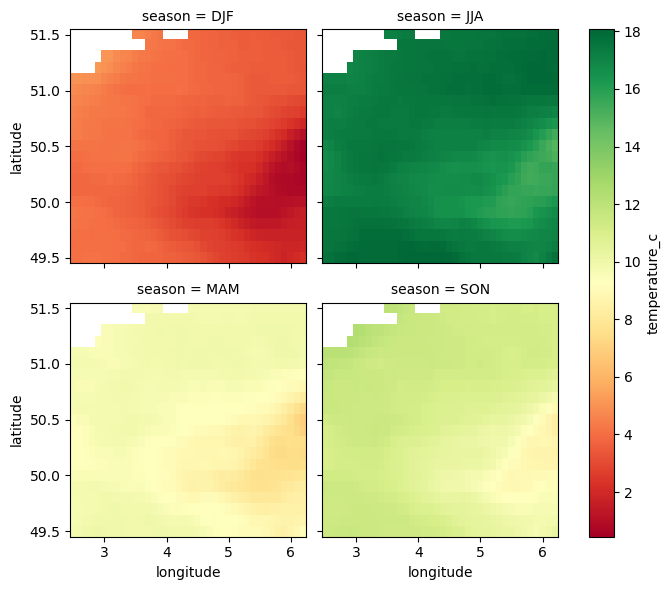

In [253]:
# See https://github.com/pydata/xarray/issues/757 for getting well-sorted groups for plotting
# Specifically, groups are ordered alphabetically, which does not make sense for seasons
ghent_seasonal_temp = ghent_seasonal_temp.sortby(xr.DataArray(['DJF','MAM','JJA','SON'], dims=['season']))

# Don't need to specify x = 'longitude', y = 'latitude'
ghent_seasonal_temp.plot.imshow(col = 'season', cmap = 'RdYlGn', col_wrap = 2);

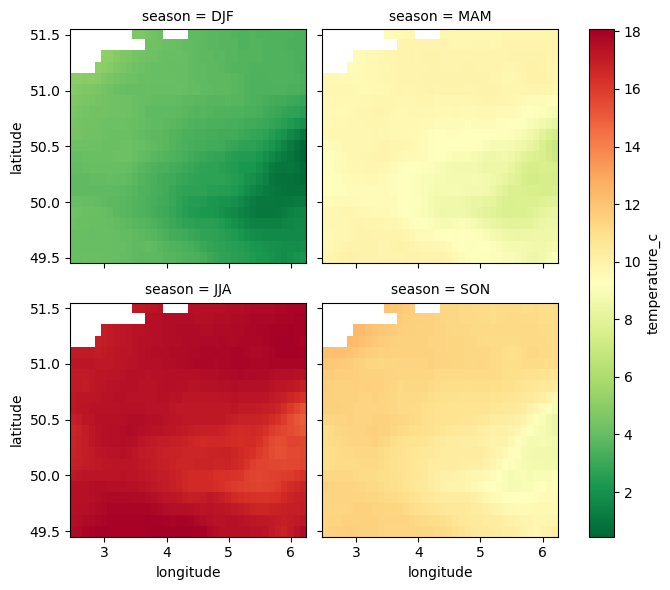

In [250]:
# See https://github.com/pydata/xarray/issues/757 for getting well-sorted groups for plotting

# Alternative solution using reindex
# I think this works better than the above because for some reason, the output of the above alternates between sorted and 
# unsorted when run
ghent_seasonal_temp = ghent_seasonal_temp.reindex(season = xr.DataArray(['DJF','MAM','JJA','SON'], dims=['season']))

# Don't need to specify x = 'longitude', y = 'latitude'
ghent_seasonal_temp.plot.imshow(col = 'season', cmap = 'RdYlGn_r', col_wrap = 2);

In [ ]:
# %load _solutions/12-xarray-advanced9.py
seaons_temp = era5_renamed["temperature_k"].groupby("time.season").mean()
# See https://github.com/pydata/xarray/issues/757 for getting well-sorted groups for plotting
seaons_temp = seaons_temp.sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'], dims=['season']))
seaons_temp.plot.imshow(col="season", cmap="Reds")

<div class="alert alert-success">

**EXERCISE 8**:

Calculate the average temperature of the entire region of the dataset in function of time. From this time series, use only those years for which all 12 months of the year are included in the data set and calculate the yearly average temperature.
    
Create a line plot showing the yearly average temperature in the y-axis and time in the x-axis.

<details><summary>Hints</summary>

* You need to calculate the average (`mean`) temperature in function of time, i.e. aggregate over both the `longitude` and `latitude` dimensions.
* Year 2021 is only available till June, so exclude the year (e.g. slice till 2020).
* Resample to yearly values.
* As the result is a DataArray with a single dimension, the default `plot` will show a line, but you can be more explicit by saying `.plot.line()`.

</details>    
    
</div>

In [267]:
# This groups by year, and returns a count of number of datapoints per pixel
months_per_pixel = era5_renamed['temperature_c'].groupby("time.year").count(dim = ['time'])

# Only pixels in which the max number of months is 12 contain all months of the year
max_months_per_pixel = months_per_pixel.max(dim = ['latitude', 'longitude'])

# Boolean array where True means there are 12 months in that year
max_months_per_pixel == 12

<xarray.DataArray 'temperature_c' (year: 41)>
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False])
Coordinates:
  * year     (year) int64 1981 1982 1983 1984 1985 ... 2017 2018 2019 2020 2021

In [276]:
# Group by year and find the mean of each year
era5_yearly_by_pixel = era5_renamed['temperature_c'].groupby("time.year").mean() 

In [282]:
# average over the entire scene, then select the years in which there were 12 months
# need to look into sel a bit more - what exactly can you use to subselect
era5_full_year = era5_yearly_by_pixel.mean(dim = ['latitude', 'longitude']).sel(year = (max_months_per_pixel == 12))

era5_full_year

<xarray.DataArray 'temperature_c' (year: 40)>
array([ 9.230247 ,  9.954272 ,  9.9575   ,  9.318986 ,  8.428444 ,
        8.875464 ,  8.72938  , 10.156663 , 10.650387 , 10.645258 ,
        9.475921 , 10.123074 ,  9.632004 , 10.677141 , 10.416763 ,
        8.560203 , 10.059959 ,  9.888617 , 10.49944  , 10.487127 ,
       10.01728  , 10.628994 , 10.545497 , 10.033453 , 10.338734 ,
       10.667305 , 10.731312 , 10.067109 , 10.208469 ,  8.933394 ,
       10.949282 , 10.011774 ,  9.56374  , 11.240792 , 10.704918 ,
       10.4745865, 10.924992 , 11.429031 , 11.11025  , 11.791906 ],
      dtype=float32)
Coordinates:
  * year     (year) int64 1981 1982 1983 1984 1985 ... 2016 2017 2018 2019 2020

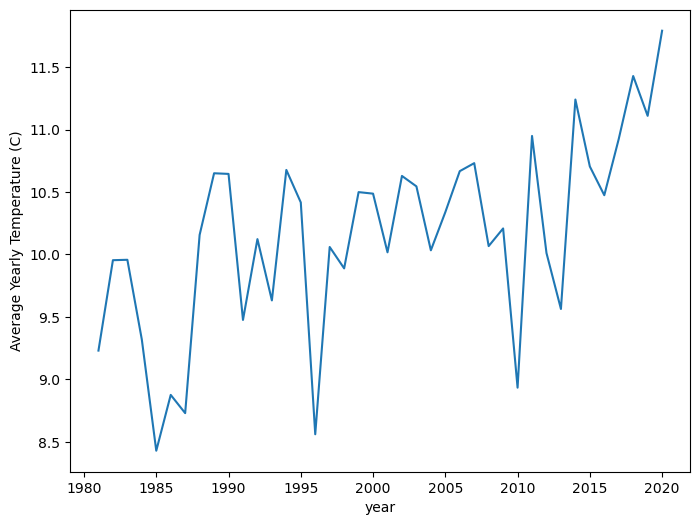

In [286]:
f, ax = plt.subplots(figsize = (8,6))

era5_full_year.plot.line(x = 'year', ax = ax)

ax.set_ylabel('Average Yearly Temperature (C)');

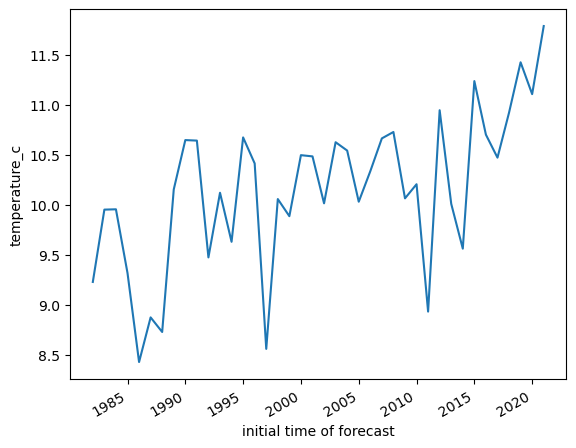

In [293]:
era5_monthly_temp = era5_renamed['temperature_c'].mean(dim = ['latitude', 'longitude']).sel(time = slice("1980", "2020"))

era5_monthly_temp.resample(time = '1Y').mean().plot.line()

In [ ]:
# %load _solutions/12-xarray-advanced10.py

# Looks like their answer simply selects up to 2020 manually
temp_mean = era5_renamed["temperature_k"].mean(dim=["latitude", "longitude"]).sel(time=slice("1981", "2020"))
temp_mean.resample(time="Y").mean().plot.line(figsize=(12, 5))

<div class="alert alert-success">

**EXERCISE 9**:
    
Create the yearly total snowfall from 1991 up to 2005 and convert the snowfall into cm.  Make a plot (`imshow`) with each of the individual years in a separate subplot divided into 3 rows and 5 columns.
    
Make sure to update the name of the snowfall variable and/or colorbar label to make sure it defines the unit in cm.
 

<details><summary>Hints</summary>

* When selecting time series data from a coordinate with datetime-aware data, one can use strings to define a date. In combination with `slice`, the selection of the required years becomes `slice("1991", "2005")`.
* From montly to yearly data is a `resample` of the data.
* Use `.rename(NEW_NAME)` to update the name of a `DataArray`
* xarray supports _facetting_ directly, check out the `col` and `col_wrap` parameters in the plot functions of xarray or check http://xarray.pydata.org/en/stable/user-guide/plotting.html#faceting.
* To update the colorbar unit use, the `cbar_kwargs` option.

</details>    
    
</div>

In [296]:
yearly_snowfall = era5_renamed['snowfall_m'].sel(time = slice("1991", "2005")).resample(time = '1Y').sum() * 100

yearly_snowfall

<xarray.DataArray 'snowfall_m' (time: 15, latitude: 21, longitude: 38)>
array([[[0.        , 0.        , 0.        , ..., 0.07025599,
         0.07044878, 0.07064007],
        [0.        , 0.        , 0.        , ..., 0.07423609,
         0.07339865, 0.07292349],
        [0.        , 0.        , 0.        , ..., 0.07819235,
         0.07654503, 0.07543135],
        ...,
        [0.04508309, 0.04615225, 0.04732031, ..., 0.14261678,
         0.1347853 , 0.12745875],
        [0.04368927, 0.04460365, 0.04564058, ..., 0.1376586 ,
         0.13223124, 0.12694076],
        [0.04332438, 0.04409291, 0.04498046, ..., 0.13114828,
         0.12646896, 0.12159776]],

       [[0.        , 0.        , 0.        , ..., 0.0138158 ,
         0.01490153, 0.01596194],
        [0.        , 0.        , 0.        , ..., 0.0159774 ,
         0.01729466, 0.01852699],
        [0.        , 0.        , 0.        , ..., 0.01821164,
         0.01972634, 0.02117734],
...
        [0.06894432, 0.07056203, 0.07229   , ..., 0.24486594,
         0.22577234, 0.20836554],
        [0.074495  , 0.0759488 , 0.07759538, ..., 0.22564828,
         0.21454337, 0.20387453],
        [0.07887166, 0.07981602, 0.08082073, ..., 0.22135285,
         0.2121497 , 0.20248182]],

       [[0.        , 0.        , 0.        , ..., 0.16806088,
         0.1674937 , 0.16698521],
        [0.        , 0.        , 0.        , ..., 0.16707721,
         0.16828589, 0.16932115],
        [0.        , 0.        , 0.        , ..., 0.1664877 ,
         0.16913694, 0.17164797],
        ...,
        [0.09515788, 0.09391885, 0.09290073, ..., 0.27233398,
         0.25622714, 0.24140534],
        [0.09643119, 0.09468161, 0.09322707, ..., 0.25448185,
         0.2445085 , 0.23487118],
        [0.09898059, 0.09767618, 0.09673517, ..., 0.24312623,
         0.23529194, 0.2268862 ]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 51.5 51.4 51.3 51.2 ... 49.8 49.7 49.6 49.5
  * longitude  (longitude) float64 2.5 2.6 2.7 2.8 2.9 ... 5.8 5.9 6.0 6.1 6.2
  * time       (time) datetime64[ns] 1991-12-31 1992-12-31 ... 2005-12-31

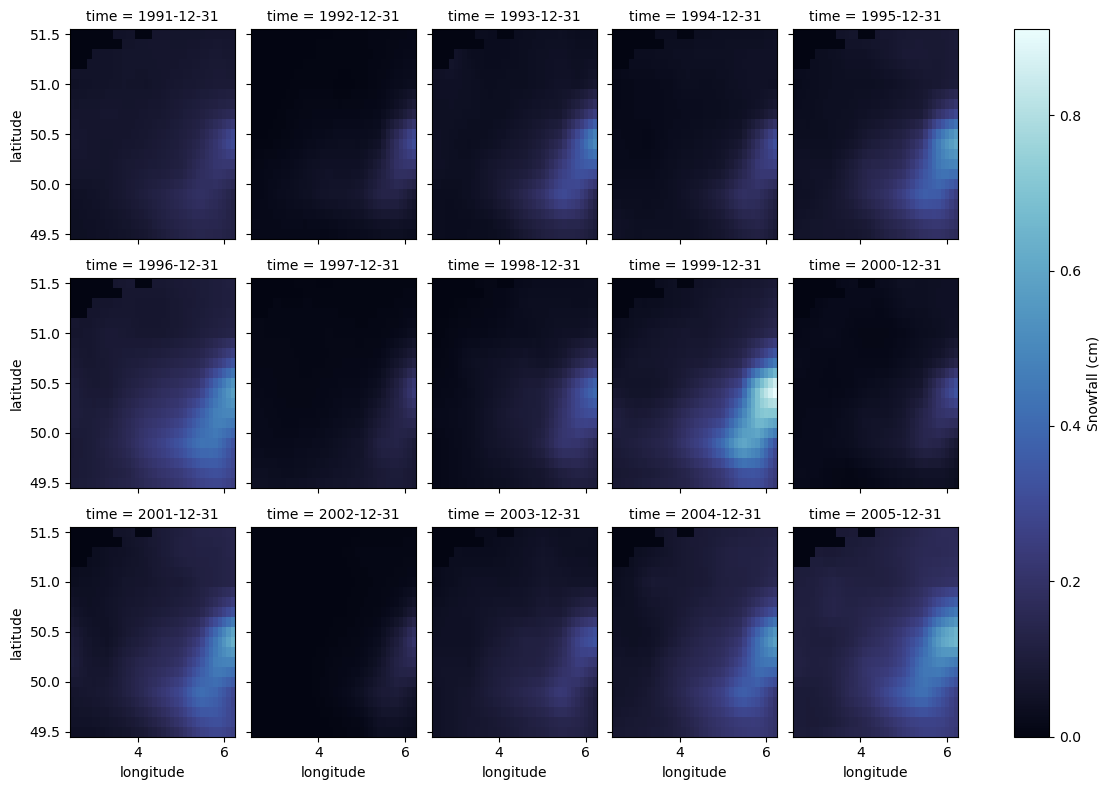

In [311]:
# Alternatively, rather than renaming using cbar_kwargs, you can use 
yearly_snowfall.plot.imshow(col = 'time', col_wrap = 5, cmap = cmocean.cm.ice, figsize = (12,8),
                            cbar_kwargs = {'label': 'Snowfall (cm)'});

# img.axes[0].colorbar.set_label('Snowfall (cm)')

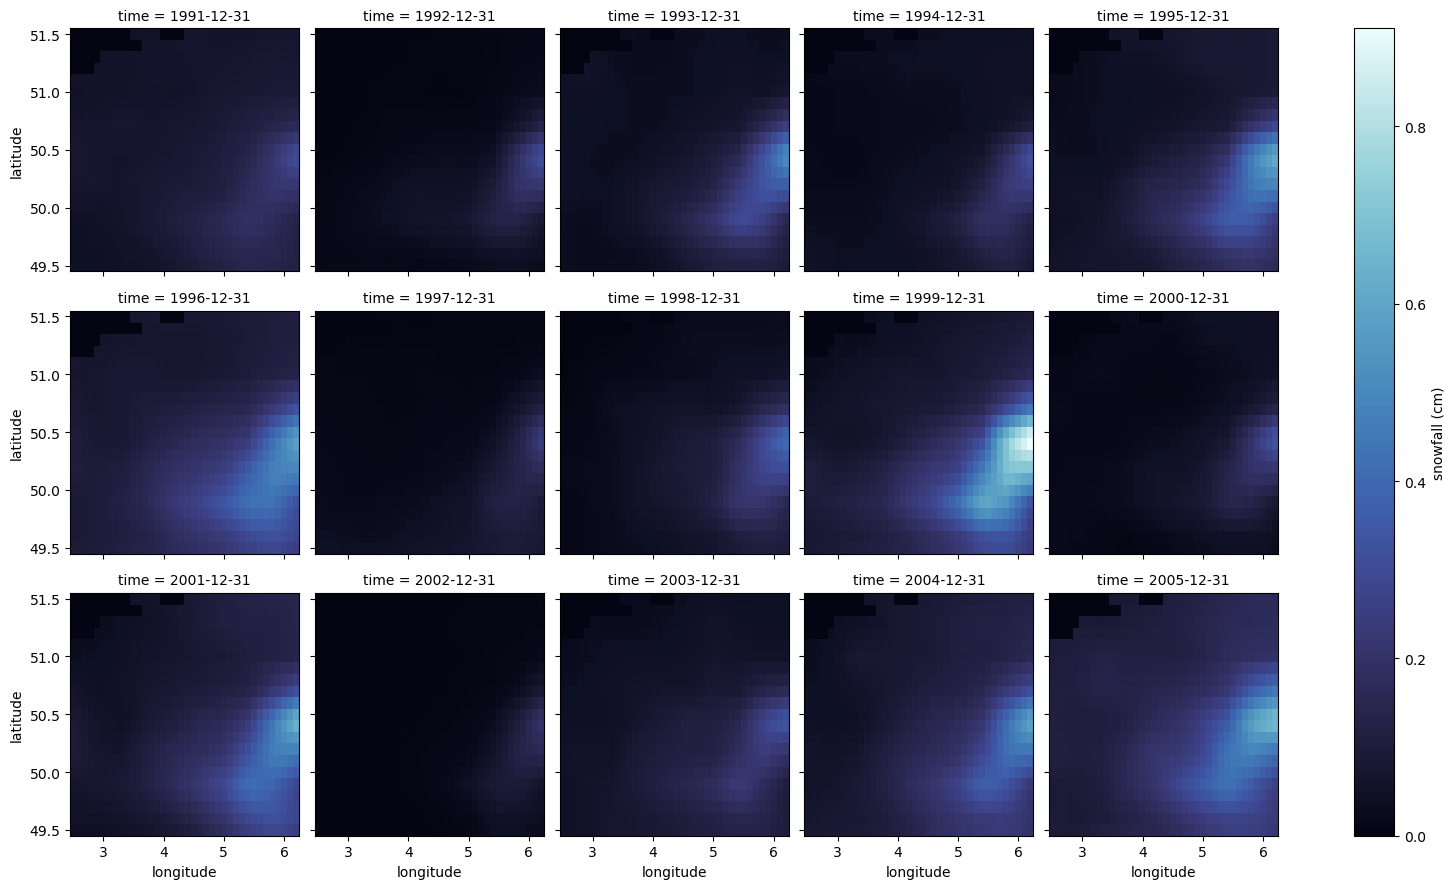

In [310]:
# %load _solutions/12-xarray-advanced11.py
snowfall_1991_2005 = era5_renamed.sel(time=slice("1991", "2005"))["snowfall_m"]
snowfall_yearly = snowfall_1991_2005.resample(time="Y").sum()*100
snowfall_yearly = snowfall_yearly.rename("snowfall_cm")
snowfall_yearly.plot.imshow(col="time", col_wrap=5, cmap=cmocean.cm.ice, 
                            cbar_kwargs={"label": "snowfall (cm)"})

## xarray lazy data loading

Values are only read from disk when needed. For example, the following statement only reads the coordinate information and the metadata. The data itself is not yet loaded:

In [312]:
data_file = "./data/2016-2017_global_rain-temperature.nc"

In [314]:
ds = xr.open_dataset(data_file)

ds

<xarray.Dataset>
Dimensions:        (y: 347, x: 720, year: 2)
Coordinates:
  * y              (y) float64 83.25 82.75 82.25 81.75 ... -88.75 -89.25 -89.75
  * x              (x) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * year           (year) int64 2016 2017
Data variables:
    precipitation  (year, y, x) float32 ...
    temperature    (year, y, x) float32 ...

`load()` will explicitly load the data into memory:

In [ ]:
xr.open_dataset(data_file).load()

## (Optional) From DataSet to DataArray and back

Consider the sentinel images of Gent used in a previous notebook:

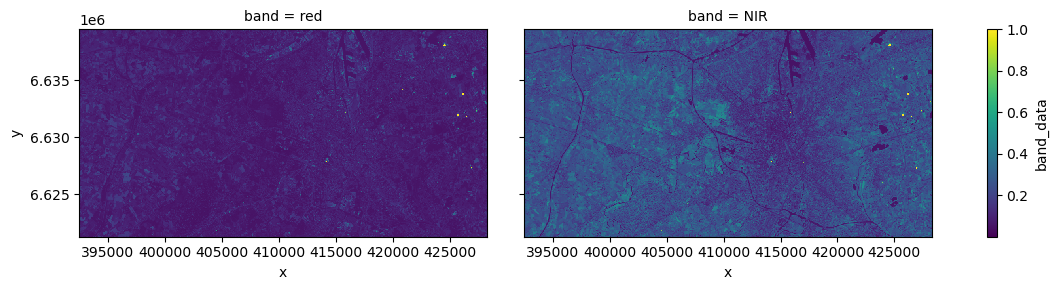

In [323]:
gent_file = "./data/gent/raster/2020-09-17_Sentinel_2_L1C_B0408.tiff"
gent_array = xr.open_dataarray(gent_file, engine="rasterio")

# Rename bands
gent_array = gent_array.assign_coords(band=("band", ["red", "NIR"]))

img = gent_array.plot.imshow(col="band", figsize = (12,3))

# Note that because this is a FacetGrid object we need to loop over each axes to set aspect
for ax in img.axs.flat:
    ax.set_aspect('equal')

The data is a `xarray.DataArray` with 3 dimensions and corresponding coordinates. Assigning the names `b4` and `b8` to the individual bands, makes the data more self-describing:

In [ ]:
gent_array = gent_array.assign_coords(band=("band", ["b4", "b8"]))
gent_array

In case one wants to work with the different bands as DataSet variables instead of a dimension of a single DataArray, the conversion `to_dataset` can be done, defining the dimension to convert to data set variables, e.g.

In [325]:
gent_array

<xarray.DataArray 'band_data' (band: 2, y: 317, x: 625)>
array([[[0.078202, 0.088396, ..., 0.104005, 0.086397],
        [0.102205, 0.075898, ..., 0.065705, 0.065507],
        ...,
        [0.070298, 0.069505, ..., 0.089006, 0.059907],
        [0.070603, 0.0748  , ..., 0.067597, 0.082994]],

       [[0.273594, 0.256992, ..., 0.245197, 0.232105],
        [0.255695, 0.231998, ..., 0.223301, 0.231006],
        ...,
        [0.2822  , 0.2925  , ..., 0.262196, 0.379797],
        [0.288502, 0.248096, ..., 0.338796, 0.372198]]])
Coordinates:
  * band         (band) <U3 'red' 'NIR'
  * x            (x) float64 3.925e+05 3.926e+05 ... 4.282e+05 4.283e+05
  * y            (y) float64 6.639e+06 6.639e+06 ... 6.621e+06 6.621e+06
    spatial_ref  int32 ...
Attributes:
    AREA_OR_POINT:  Area

In [324]:
# This converts the original band coords into individual slices of data variables
gent_ds = gent_array.to_dataset(dim="band")
gent_ds

<xarray.Dataset>
Dimensions:      (y: 317, x: 625)
Coordinates:
  * x            (x) float64 3.925e+05 3.926e+05 ... 4.282e+05 4.283e+05
  * y            (y) float64 6.639e+06 6.639e+06 ... 6.621e+06 6.621e+06
    spatial_ref  int32 ...
Data variables:
    red          (y, x) float64 0.0782 0.0884 0.1751 ... 0.05769 0.0676 0.08299
    NIR          (y, x) float64 0.2736 0.257 0.2479 ... 0.3324 0.3388 0.3722
Attributes:
    AREA_OR_POINT:  Area

Consider the calculation of the NDVI for Gent using a xarray DataArray:

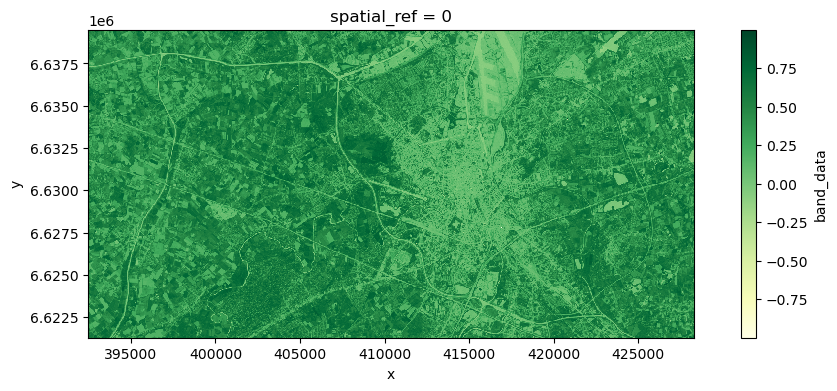

In [328]:
ndvi_array = (gent_array.sel(band="NIR") - gent_array.sel(band="red"))/(gent_array.sel(band="NIR") + gent_array.sel(band="red"))
ax = ndvi_array.plot.imshow(cmap="YlGn", figsize = (12,4))
ax.axes.set_aspect('equal')

One might find the usage of data variable in this case more convenient, as it provides the ability to:

1. work with the variable names directly
2. Add the output tot the data set as a new variable
3. The output can be converted to an Array again using `to_array`

For example:

<xarray.DataArray (layer: 3, y: 317, x: 625)>
array([[[0.07820249, 0.08839551, 0.17509728, ..., 0.10339513,
         0.10400549, 0.08639658],
        [0.10220493, 0.07589837, 0.0854963 , ..., 0.07319753,
         0.06570535, 0.06550698],
        [0.10110628, 0.08000305, 0.07699702, ..., 0.06880293,
         0.07330434, 0.07049668],
        ...,
        [0.07269398, 0.07420462, 0.06810101, ..., 0.14090181,
         0.1008011 , 0.06829938],
        [0.07029831, 0.06950484, 0.06720073, ..., 0.0733959 ,
         0.08900587, 0.05990692],
        [0.07060349, 0.07479973, 0.07240406, ..., 0.05769436,
         0.06759747, 0.08299382]],

       [[0.27359426, 0.25699245, 0.24789807, ..., 0.28369574,
         0.24519722, 0.23210498],
        [0.25569543, 0.23199817, 0.25969329, ..., 0.25510033,
         0.22330053, 0.23100633],
        [0.22659648, 0.24240482, 0.26790265, ..., 0.2717937 ,
         0.28119326, 0.30969711],
...
        [0.2695964 , 0.25340658, 0.29199664, ..., 0.24559396,
         0.29170672, 0.30899519],
        [0.28220035, 0.29250019, 0.29359884, ..., 0.21399252,
         0.26219577, 0.37979706],
        [0.28850233, 0.24809644, 0.26190585, ..., 0.33240253,
         0.33879606, 0.37219806]],

       [[0.55541097, 0.48813784, 0.17210779, ..., 0.46578366,
         0.40432598, 0.45748096],
        [0.42886378, 0.50698781, 0.5046415 , ..., 0.55407855,
         0.54530095, 0.5581515 ],
        [0.38293909, 0.50371527, 0.5535106 , ..., 0.59598584,
         0.58643251, 0.62915396],
        ...,
        [0.57524964, 0.54699581, 0.62176363, ..., 0.27087528,
         0.48637406, 0.63795195],
        [0.60114281, 0.61600067, 0.62748996, ..., 0.48922162,
         0.49313521, 0.72751249],
        [0.60678168, 0.53669486, 0.56684468, ..., 0.70420497,
         0.66733   , 0.63534578]]])
Coordinates:
  * x            (x) float64 3.925e+05 3.926e+05 ... 4.282e+05 4.283e+05
  * y            (y) float64 6.639e+06 6.639e+06 ... 6.621e+06 6.621e+06
    spatial_ref  int32 ...
  * layer        (layer) object 'red' 'NIR' 'ndvi'
Attributes:
    AREA_OR_POINT:  Area

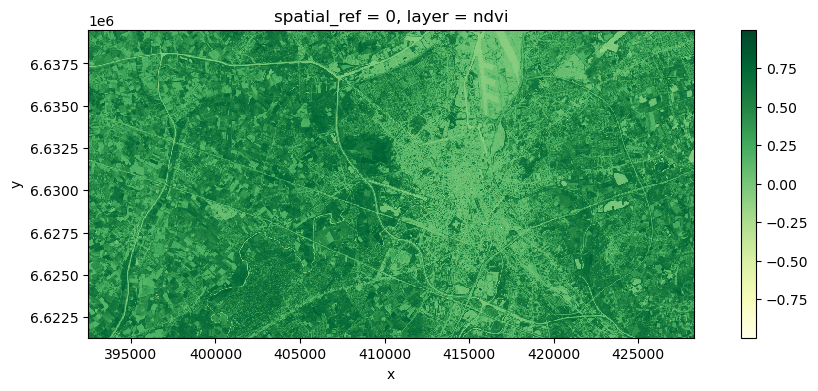

In [331]:
gent_ds["ndvi"] = (gent_ds["NIR"] - gent_ds["red"])/(gent_ds["NIR"] + gent_ds["red"])

# Convert back into DataArray, with variables being assigned to the "layer" coords
gent_ndvi_array = gent_ds.to_array(dim="layer")

# Now has three layer coords: red, NIR, ndvi
display(gent_ndvi_array)

ax = gent_ndvi_array[2].plot.imshow(cmap="YlGn", figsize = (12,4))
ax.axes.set_aspect('equal')